# 지도학습-다항회귀

In [15]:
from hossam import *

from pandas import DataFrame, read_excel
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import combinations

from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, learning_curve

from sklearn.metrics import(
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

from scipy.stats import shapiro, jarque_bera, t, f

import statsmodels.api as sm
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.graphics.gofplots import qqplot as sm_qqplot

In [6]:
origin = load_data('fish_processed')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터의 전처리 버전
데이터셋 크기: (56, 4)
열 개수: 4
행 개수: 56
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB
None


,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,1.931521
1,-1.587434,-1.518703,-1.560774,3.496508
2,-1.442032,-1.417039,-1.316328,3.713572
3,-1.307815,-1.147103,-1.202633,3.960813
4,-1.173599,-1.147103,-1.026405,4.262680



### 1. 산점도 행렬 확인

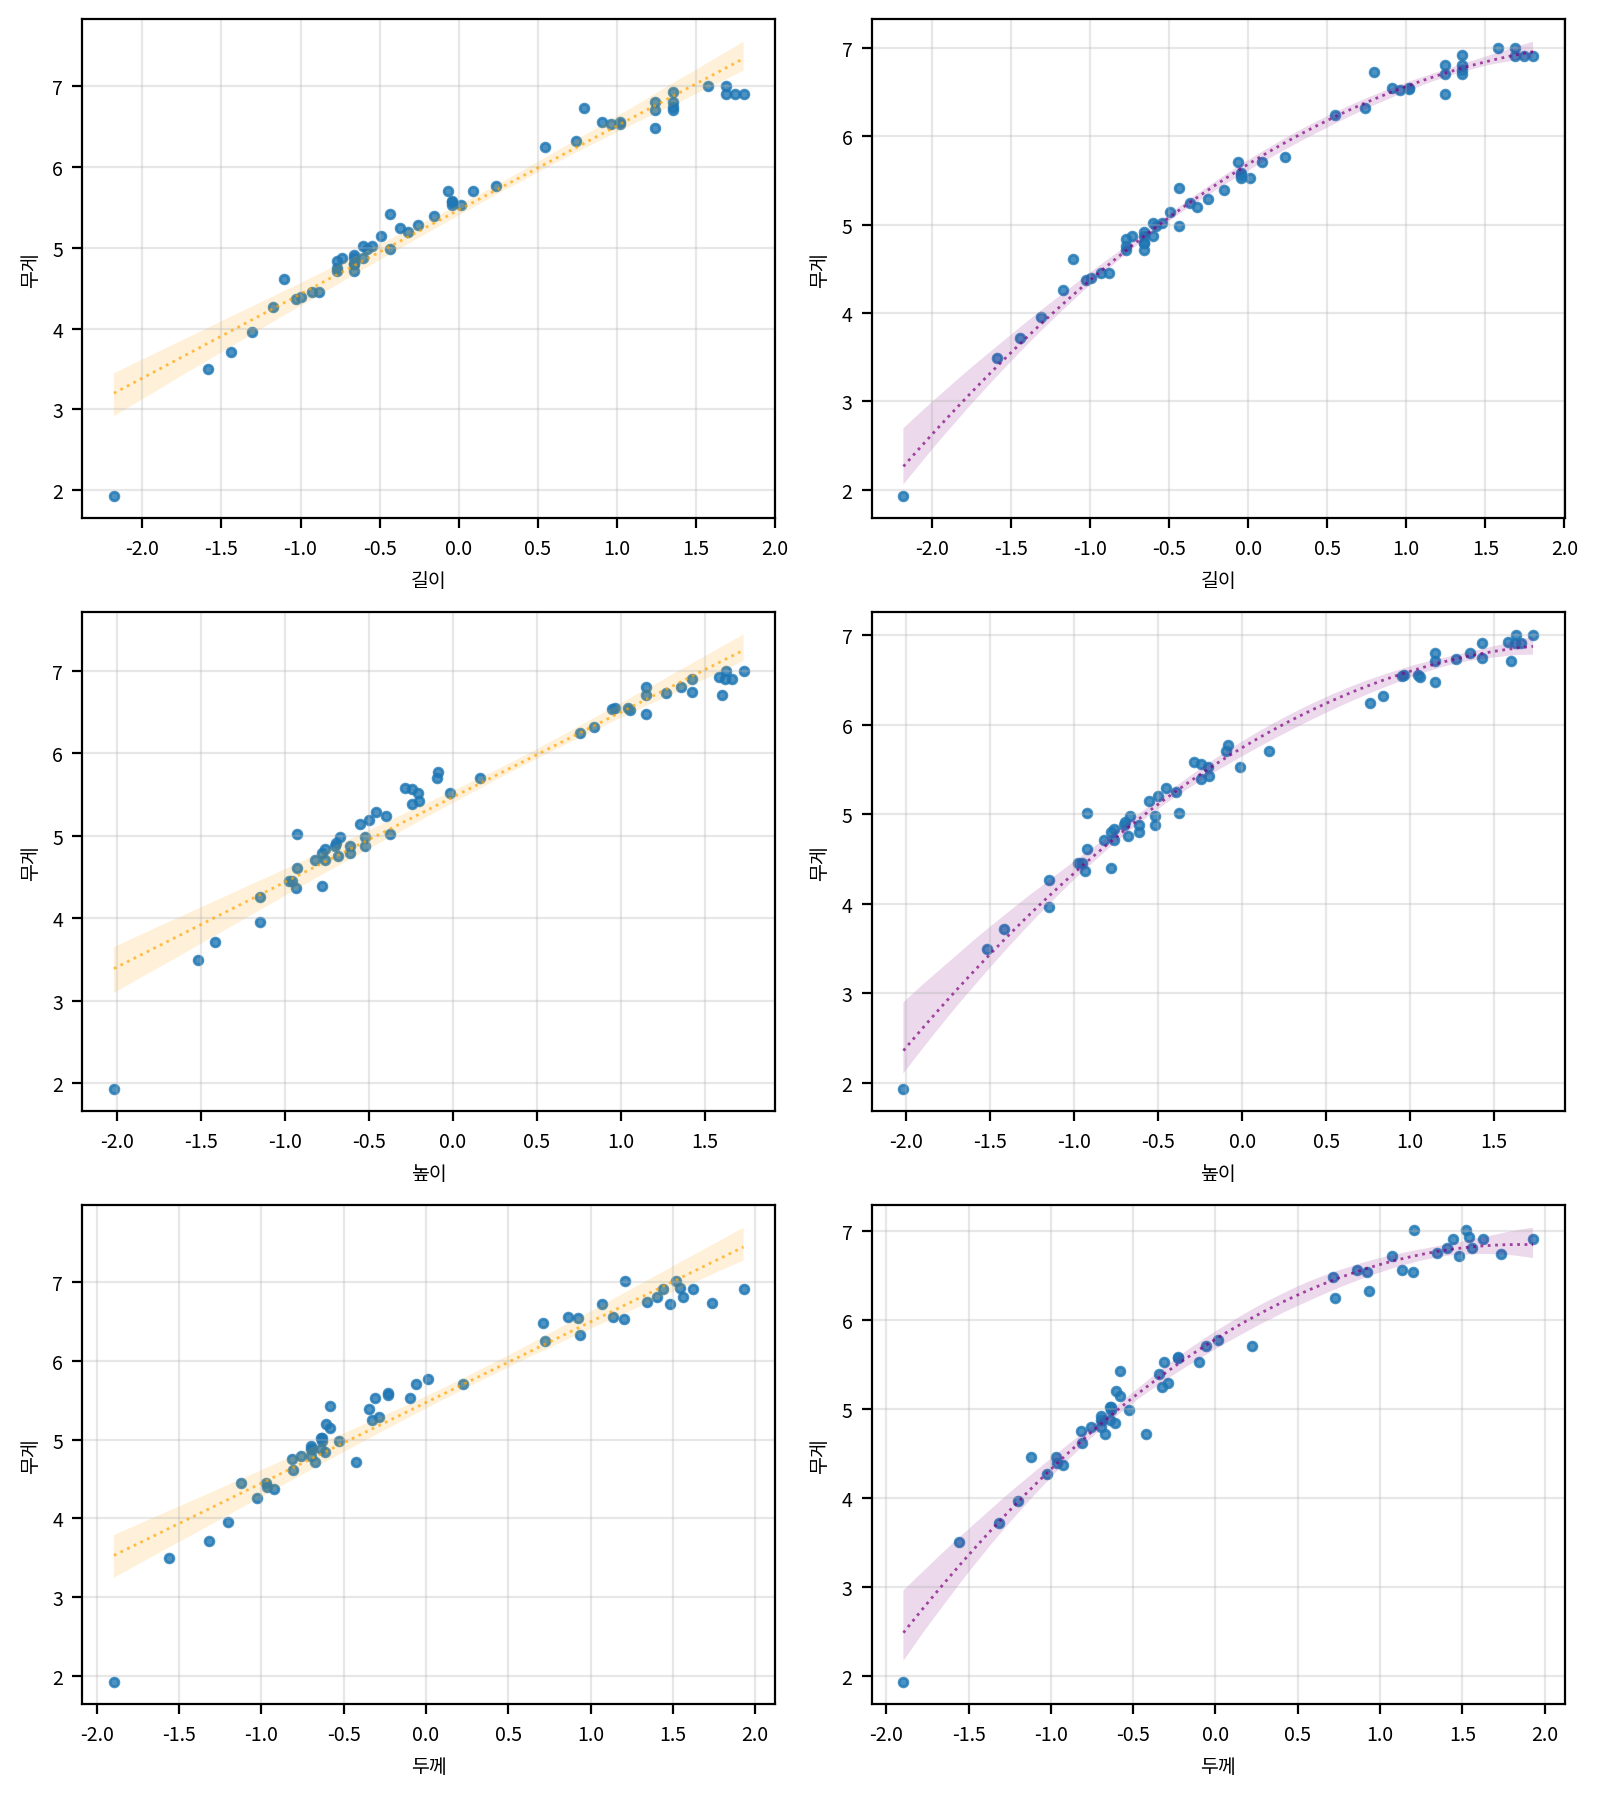

In [9]:
combo = ['길이', '높이', '두께']
size = len(combo)

figsize =(1600/my_dpi, 600 * size/my_dpi)
fig, ax = plt.subplots(size, 2, figsize=figsize, dpi=my_dpi)

for s in range(size):
    sb.regplot(
        data=origin,
        x=combo[s],
        y='무게',
        scatter_kws ={'s': 10},
        line_kws = {'color':'orange', 'linewidth': 1, 'alpha': 0.7, 'linestyle':':'},
        ax=ax[s][0]
    )
    ax[s][0].grid(True, alpha= 0.3)

    sb.regplot(
        data=origin,
        x=combo[s],
        y='무게',
        order = 2,
        scatter_kws ={'s': 10},
        line_kws = {'color':'purple', 'linewidth': 1, 'alpha': 0.7, 'linestyle':':'},
        ax=ax[s][1]
    )
    ax[s][1].grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()
plt.close()

## 1. 데이터 전처리 - 2차항 생성하기
### 1. 직접 생성

In [10]:
df1 = origin.drop('무게', axis = 1).copy()
columns = df1.select_dtypes(include = np.number).columns

for col in columns:
    df1[f'{col}^2'] = df1[col] ** 2

df1.head()

,길이,높이,두께,길이^2,높이^2,두께^2
0,-2.180225,-2.016507,-1.896175,4.753381,4.066302,3.595479
1,-1.587434,-1.518703,-1.560774,2.519946,2.306460,2.436014
2,-1.442032,-1.417039,-1.316328,2.079457,2.008000,1.732721
3,-1.307815,-1.147103,-1.202633,1.710381,1.315845,1.446326
4,-1.173599,-1.147103,-1.026405,1.377334,1.315845,1.053508


### 2. 변수가 2개 이상인 경우 2개씩 조합 가능한 모든 쌍에 대해 곱한 변수를 생성한다

In [12]:
# columns의 변수에 대해 2개씩 조합한 곱셈행 추가

for col1, col2 in combinations(columns, 2):
    df1[f'{col1} * {col2}'] = df1[col1] * df1[col2]

df1.head()

,길이,높이,두께,길이^2,높이^2,두께^2,길이 * 높이,길이 * 두께,높이 * 두께
0,-2.180225,-2.016507,-1.896175,4.753381,4.066302,3.595479,4.396440,4.134088,3.823651
1,-1.587434,-1.518703,-1.560774,2.519946,2.306460,2.436014,2.410841,2.477625,2.370352
2,-1.442032,-1.417039,-1.316328,2.079457,2.008000,1.732721,2.043416,1.898188,1.865289
3,-1.307815,-1.147103,-1.202633,1.710381,1.315845,1.446326,1.500199,1.572822,1.379544
4,-1.173599,-1.147103,-1.026405,1.377334,1.315845,1.053508,1.346238,1.204588,1.177393


### 3. 종속변수 추가

In [13]:
df1['무게'] = origin['무게']
df1.head()

,길이,높이,두께,길이^2,높이^2,두께^2,길이 * 높이,길이 * 두께,높이 * 두께,무게
0,-2.180225,-2.016507,-1.896175,4.753381,4.066302,3.595479,4.396440,4.134088,3.823651,1.931521
1,-1.587434,-1.518703,-1.560774,2.519946,2.306460,2.436014,2.410841,2.477625,2.370352,3.496508
2,-1.442032,-1.417039,-1.316328,2.079457,2.008000,1.732721,2.043416,1.898188,1.865289,3.713572
3,-1.307815,-1.147103,-1.202633,1.710381,1.315845,1.446326,1.500199,1.572822,1.379544,3.960813
4,-1.173599,-1.147103,-1.026405,1.377334,1.315845,1.053508,1.346238,1.204588,1.177393,4.262680


## 방법2 - sklearn의 전처리 기능 활용
### 1. 2차항에 대한 변수값 생성

In [16]:
poly = PolynomialFeatures(degree = 2, include_bias = False)
poly_fit = poly.fit_transform(origin[['길이','높이','두께']])
poly_fit[:3]

array([[-2.18022506, -2.0165074 , -1.89617489,  4.75338133,  4.39643997,
         4.13408802,  4.06630209,  3.8236507 ,  3.59547922],
       [-1.58743393, -1.51870326, -1.56077354,  2.51994649,  2.41084109,
         2.47762488,  2.3064596 ,  2.37035187,  2.43601404],
       [-1.44203233, -1.41703904, -1.31632849,  2.07945725,  2.04341611,
         1.89818824,  2.00799964,  1.86528885,  1.73272069]])

### 2. 각 변수별로 Feature의 이름 확인

In [17]:
poly.get_feature_names_out()

array(['길이', '높이', '두께', '길이^2', '길이 높이', '길이 두께', '높이^2', '높이 두께',
       '두께^2'], dtype=object)

### 3. 데이터프레임으로 재구성

In [18]:
df2 = DataFrame(poly_fit, columns = poly.get_feature_names_out())

# 종속변수 복사
df2['무게'] = origin['무게']
df2.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게
0,-2.180225,-2.016507,-1.896175,4.753381,4.396440,4.134088,4.066302,3.823651,3.595479,1.931521
1,-1.587434,-1.518703,-1.560774,2.519946,2.410841,2.477625,2.306460,2.370352,2.436014,3.496508
2,-1.442032,-1.417039,-1.316328,2.079457,2.043416,1.898188,2.008000,1.865289,1.732721,3.713572
3,-1.307815,-1.147103,-1.202633,1.710381,1.500199,1.572822,1.315845,1.379544,1.446326,3.960813
4,-1.173599,-1.147103,-1.026405,1.377334,1.346238,1.204588,1.315845,1.177393,1.053508,4.262680


## 3. 2차항이 추가된 데이터 분포 확인
### 1. 독립변수의 데이터 분포

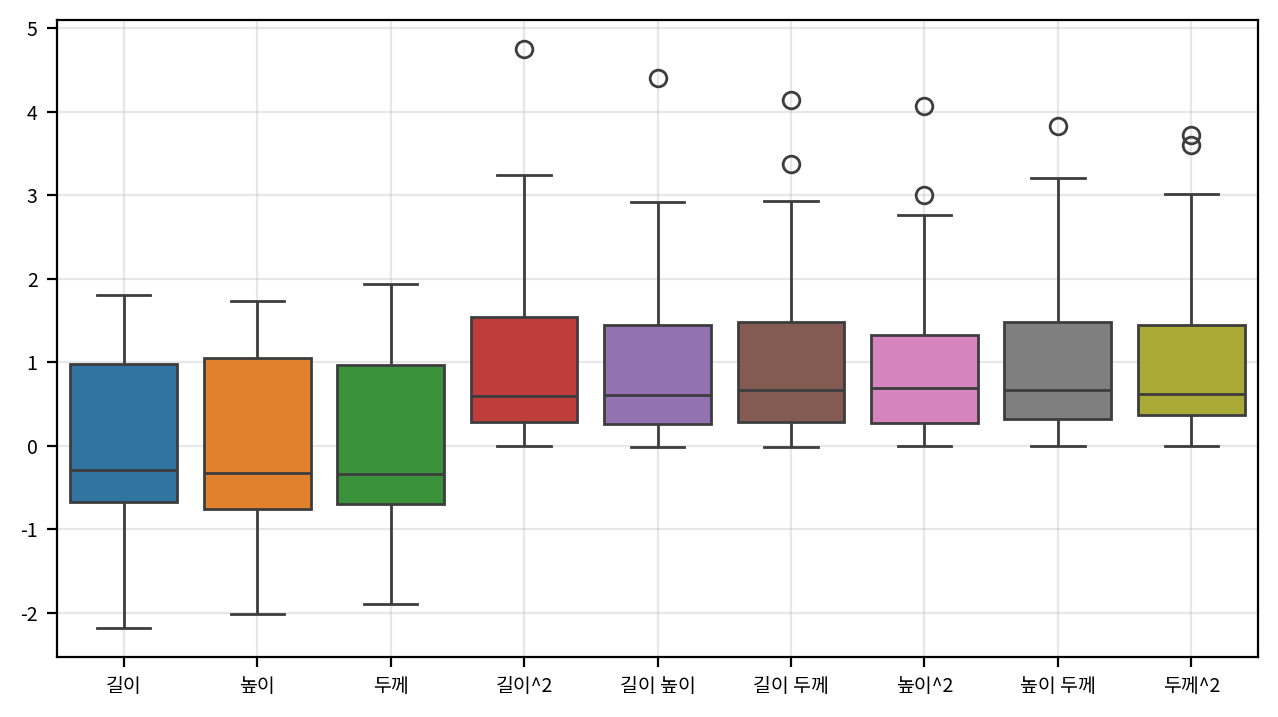

In [20]:
figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)
sb.boxplot(data = df2.drop('무게', axis = 1))
ax.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()
plt.close()

### 2. 데이터 스케일링

In [21]:
df = df2.drop('무게', axis = 1)
scaler = StandardScaler()
df3 = DataFrame(scaler.fit_transform(df), columns = df.columns)
df3['무게'] = df2['무게']
df3.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게
0,-2.180225,-2.016507,-1.896175,3.708586,3.556234,3.381553,3.290051,3.122527,2.755507,1.931521
1,-1.587434,-1.518703,-1.560774,1.501806,1.485983,1.608680,1.401792,1.525106,1.524553,3.496508
2,-1.442032,-1.417039,-1.316328,1.066574,1.102893,0.988523,1.081554,0.969957,0.777897,3.713572
3,-1.307815,-1.147103,-1.202633,0.701903,0.536517,0.640291,0.338893,0.436042,0.473845,3.960813
4,-1.173599,-1.147103,-1.026405,0.372830,0.375993,0.246179,0.338893,0.213843,0.056807,4.262680


### 3. 스케일링 결과 확인

In [ ]:
figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)
sb.boxplot(data = df2.drop('무게', axis = 1))
ax.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()
plt.close()